## Exercise 1.2
## Classification of MNIST digits with a convolutional neural network

In this exercise we will classify MNIST digits again, but this time we will use a convolutional neural network (CNN).

First we import the modules we need

In [111]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We check that this script has a GPU available

In [112]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We import the MNIST dataset, which is built into pytorch

In [113]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

training_aug_set = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor()
]))
train_loader_aug = DataLoader(training_aug_set, batch_size=batch_size, shuffle=True, num_workers=1)

You should implement a network to classify MNIST digits. 
The network should consist of two parts, a part with convolutions and one with fully connected layers.
The convolutional part we will call `convolutional`, and it should contain the follwing:
* two convolutional layers with 8 features
* a $2\times2$ max pooling layer
* two convolutional layers with 16 features

The convolutions should be $3\times 3$, and should not change the size of the output. What does this mean that the stride and padding should be?

For example check the documentation of the `nn` module https://pytorch.org/docs/stable/nn.html

**Remember**: There's a specific type of layer that you should always have after a convolution or a fully connected layer. What is this type of layer called?

In [114]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
#         self.convolutional = nn.Sequential(
#                 nn.Conv2d(1, 16, 3, padding=1),   # 28x28 → 28x28x16
#                 nn.ReLU(),
#                 nn.MaxPool2d(2, 2),              # → 14x14x16
#                 nn.Conv2d(16, 40, 3, padding=1),  # 14x14 → 14x14x40
#                 nn.ReLU(),
#                 nn.MaxPool2d(2, 2)               # → 7x7x40
# )
        self.convolutional = nn.Sequential(
                nn.Conv2d(1, 8, 3, padding=1),   # 28x28 → 28x28x8
                nn.Conv2d(8, 8, 3, padding=1),   # 28x28 → 28x28x16
                nn.MaxPool2d(2, 2),              # → 14x14x32
                nn.Conv2d(8, 16, 3, padding=1),
                nn.Conv2d(16, 16, 3, padding=1),  
        )
        self.fully_connected = nn.Sequential(
                nn.Linear(14*14*16, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

We instantiate a copy of our network, transfer it to the GPU if it's available.
We also check if the dimensions of our network match.

In [115]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 16, 14, 14])


We train this network for five epochs

In [116]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader_aug), total=len(train_loader_aug)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 89.5%	 test: 96.6%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 96.9%	 test: 97.7%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 97.7%	 test: 98.0%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 98.1%	 test: 98.1%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 98.3%	 test: 98.2%


Hopefully you now have a model that's able to achieve decent performance on MNIST.
It should have around 97.5% accuracy on the test set after the first epoch.

* Why is the accuracy on the training set higher than on the test set? (recall from machine learning)

* Why does it have higher accuracy on the test set than the training set after the first epoch?

   hint: it's related to how the train accuracy is computed

### Data augmentation
 * Add random rotations to the MNIST digits during training (you have to go back and modify the dataloader)
 
  hint: you can use `transforms.RandomRotation` 
  
  hint: you can combine multiple transforms into one with `transforms.Compose`

How does this affect your training and testing loss?

 * Try plotting some of the augmented images, to visually confirm what your augmentation is doing.

 * Try adding another type of data augmentation.

### Explore the model
What has the model learned? You can access all the weights in the model with `model.parameters()`. Here we just print the shape.
 - Try showing images of the filters in the first layer. 
 - Can you from the dimensions of the weights alone identify which layer it is in our model?

ValueError: Input could not be cast to an at-least-1D NumPy array

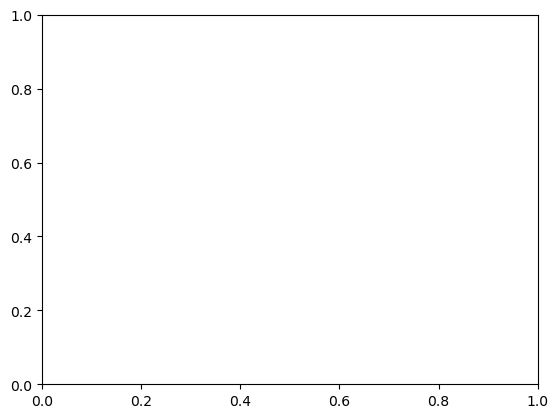

In [ ]:
[w.shape for w in model.parameters()]
plt.plot([training_aug_set])

### Dropout
 * Try adding dropout to your model.
 
You can add it between the convolutional layers and or in the fully connected part.

Remember to call `net.train()` and `net.eval()` to change the model from test to training state, so it knows when you want it to apply dropout.

## Already done?

Try to explore extracting features at different layers of the model and visualizing the corresponding representation of your data using e.g. t-SNE or PCA. Try to understand how those two techniques differ